In [2]:
import os

DATASET_PATH = r'C:\Users\joelm\Desktop\RATTRAPAGE PROJET 419\Dataset_BUSI_with_GT'
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

     

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os

# **Lecture et pretraitement des données**

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

    

Found 1578 files belonging to 3 classes.


# **Recupération des differntes classes dans nos données**

In [5]:

class_labels = dataset.class_names
class_labels

['benign', 'malignant', 'normal']

# **Affichage de quelques images de la bd**

(32, 256, 256, 3)
<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 1, 2, 0, 0, 0, 1, 0, 1, 1, 1, 1, 2, 0, 1, 0, 0, 2, 0, 0, 2, 0,
       1, 1, 2, 0, 0, 0, 0, 1, 0, 0])>>


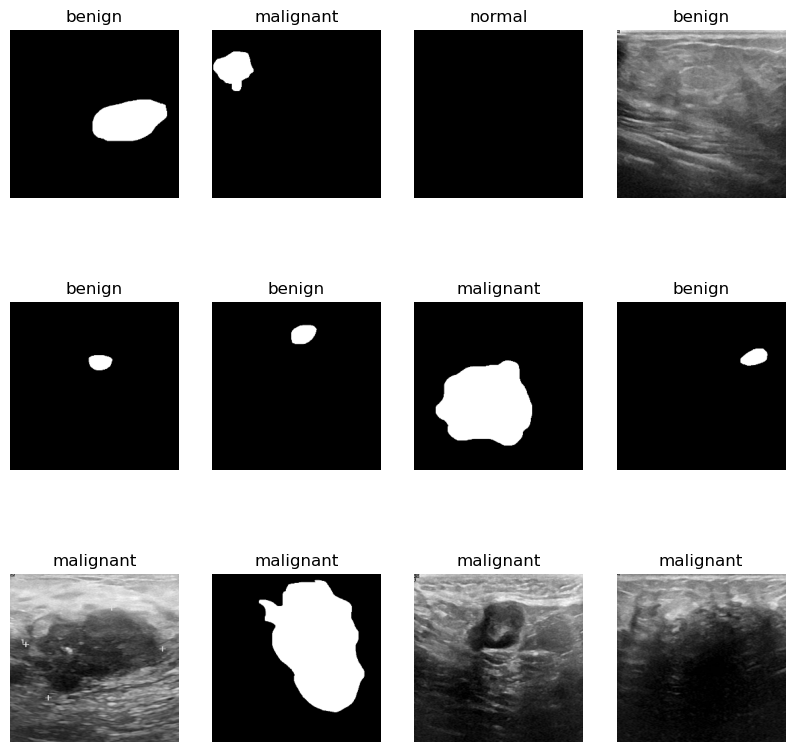

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy)
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_labels[label_batch[i]])
    plt.axis("off")

# **Division de notre base de données en train, val et test (80%,10%,10%)**

In [7]:
DATASET_SIZE = len(dataset)
train_size = int(0.8 * DATASET_SIZE)
val_size = int(0.10 * DATASET_SIZE)
test_size = int(0.10 * DATASET_SIZE)
dataset = dataset.shuffle(1000, seed=12)#La fonction shuffle() permet de mélanger l'ensemble de données avant de diviser les données en ensembles d'entraînement, de validation et de test.
train_dataset = dataset.take(train_size)#La méthode take() permet de prendre les premiers éléments de l'ensemble de données, 
print(len(train_dataset))
test_dataset = dataset.skip(train_size)#la méthode skip() permet de sauter les premiers éléments de l'ensemble de données.
print(len(test_dataset))
val_dataset = test_dataset.take(val_size)
print(len(val_dataset))
test_dataset = test_dataset.skip(test_size)
print(len(test_dataset))

40
10
5
5


La méthode cache() est utilisée pour stocker en cache les éléments de l'ensemble de données après leur première utilisation. Cela permet d'accélérer le processus d'entraînement car les données sont chargées en mémoire au lieu d'être relues à partir du disque.
La méthode shuffle() est utilisée pour mélanger l'ensemble de données afin de garantir que les exemples sont présentés à l'apprentissage dans un ordre aléatoire.
La méthode prefetch() permet de précharger les données pour le traitement ultérieur.

In [8]:
train_ds = train_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
print(len(train_ds),len(val_ds),len(test_ds))

40 5 5


# **Redimensionne et normalise les images**

In [9]:

from tensorflow.keras import layers

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255)
])


# **Augmentation des données**

La map()fonction prend une fonction comme argument et applique cette fonction à chaque élément de l'ensemble de données.
La prefetch()fonction est utilisée pour améliorer les performances du processus de chargement des données. Il prélève un certain nombre de lots à l'avance, de sorte que le lot suivant soit prêt à être traité au moment où le lot en cours est terminé. L' tf.data.AUTOTUNEargument indique à TensorFlow de déterminer dynamiquement la taille optimale du tampon de prélecture en fonction des ressources système disponibles.

In [10]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])




In [11]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# **Architecture du CNN**

In [12]:
from tensorflow.keras import regularizers
input_shape = (BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
n_classes=3
model=None
model = models.Sequential([
        resize_and_rescale,
        layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)






C:\Users\joelm\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 2304)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 277,891 (1.06 MB)

 Trainable params: 277,891 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(
    optimizer='adam',
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [15]:
tf.test.is_built_with_cuda()

False

In [16]:
tf.test.gpu_device_name()

''

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 34s 713ms/step - accuracy: 0.5461 - loss: 0.9637 - val_accuracy: 0.5188 - val_loss: 0.8546
Epoch 2/50


C:\Users\joelm\anaconda3\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:209: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 36s 899ms/step - accuracy: 0.5929 - loss: 0.8119 - val_accuracy: 0.6687 - val_loss: 0.8057
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.6441 - loss: 0.7961 - val_accuracy: 0.6625 - val_loss: 0.7601
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.6763 - loss: 0.7204 - val_accuracy: 0.6687 - val_loss: 0.6832
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.6845 - loss: 0.6760 - val_accuracy: 0.6750 - val_loss: 0.6580
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.6640 - loss: 0.6917 - val_accuracy: 0.6875 - val_loss: 0.6302
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6947 - loss: 0.6415 - val_accuracy: 0.7000 - val_loss: 0.6180
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.7099 - loss: 0.6221 - val_accuracy: 0.7188 - val_loss: 0.6793
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.7430 - loss: 0.6197 - val_accuracy: 0.7312 - val_loss: 0.5975


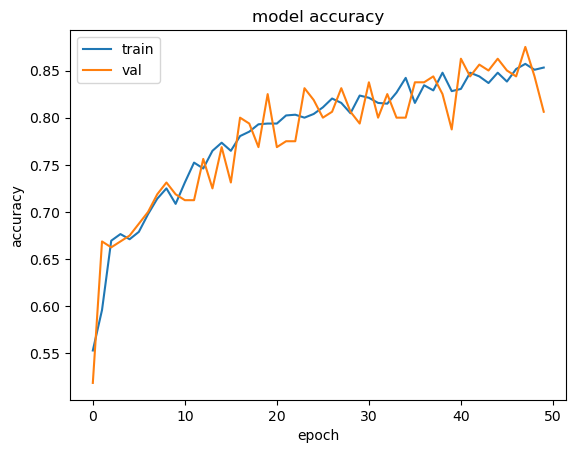

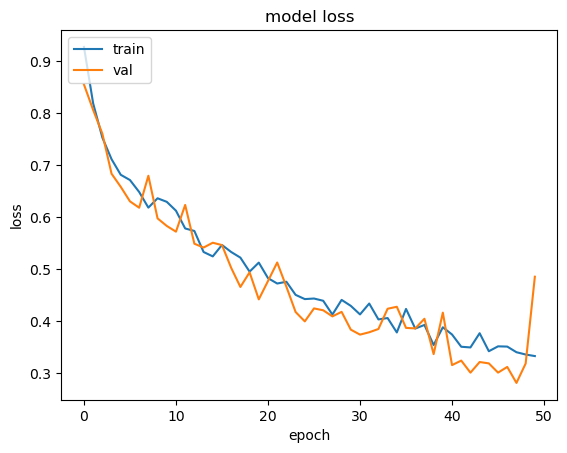

In [25]:

from tensorflow.keras.callbacks import ModelCheckpoint

# Créer un callback pour sauvegarder le meilleur modèle basé sur la performance de validation
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')



# Entraîner le modèle avec le callback
history = model.fit(
     train_ds,
     epochs=EPOCHS,
     batch_size=BATCH_SIZE,
     verbose=1,
     validation_data=val_ds,
     callbacks=[checkpoint])

  
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

  # Plot history: loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
model.evaluate(test_ds)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step - accuracy: 0.8125 - loss: 0.5374


[0.544109582901001, 0.8125]

# **Premiere prediction**

first image to predict
actual label: benign
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
predicted label: benign


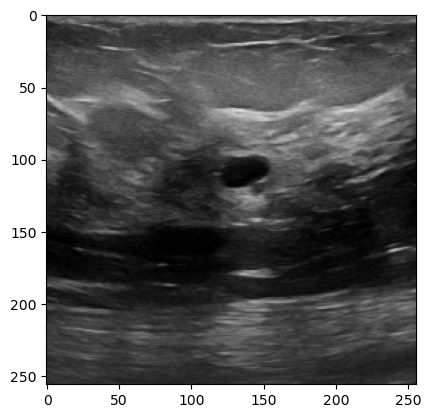

In [28]:
from tensorflow.python.ops.gen_batch_ops import batch
for image_batch, label_batch in test_ds.take(1):
  first_image = image_batch[0].numpy().astype('uint8')
  first_label = label_batch[0].numpy()
  print("first image to predict")
  plt.imshow(first_image)
  print("actual label:",class_labels[first_label])

  batch_predic = model.predict(image_batch)
  print("predicted label:", class_labels[np.argmax(batch_predic[0])])

In [29]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_labels[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# **Prediction de 12 images avec une confiance pour chaque prediction**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


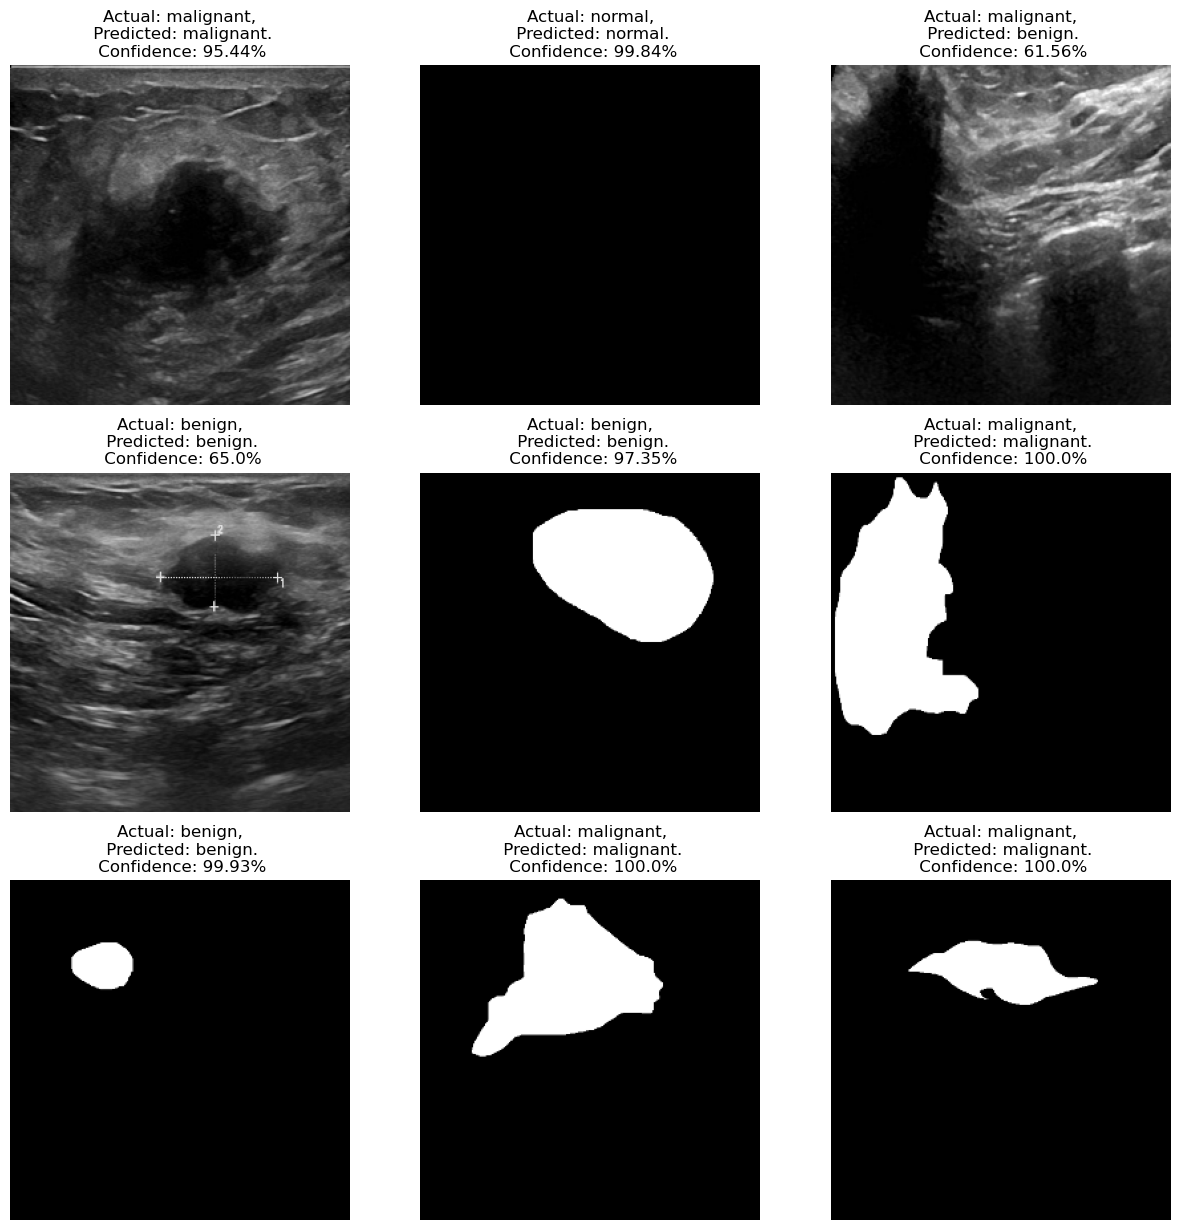

In [30]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_labels[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# **Enregistrement du model et lecture du modele par la suite**

In [31]:

model.save("mon_modele.keras")



# **Evaluation du modele sur les données de test**

In [32]:
model.evaluate(test_ds)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step - accuracy: 0.8155 - loss: 0.5079


[0.544109582901001, 0.8125]

# **Matrice de confusion**

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 263ms/step


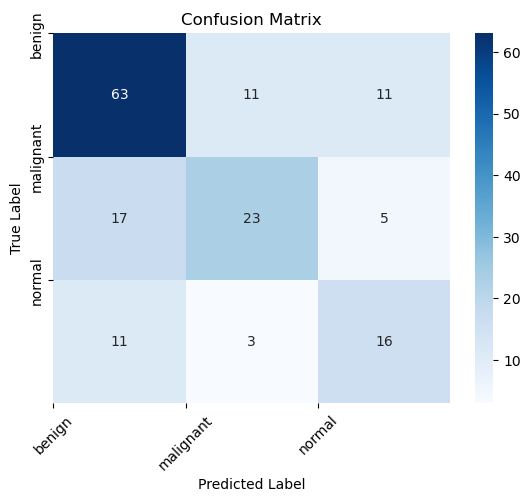

In [43]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Prédire les classes pour les données de test
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Calculer la matrice de confusion
class_names = ['benign', 'malignant', 'normal'] 
confusion_mtx = confusion_matrix(y_true, y_pred_classes, labels=range(len(class_names)))

# Afficher la matrice de confusion
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
plt.yticks(np.arange(len(class_names)), class_names)
plt.title('Confusion Matrix')
plt.show()
 

# **F1 score et Rappel**

In [41]:
from sklearn.metrics import classification_report

class_names = ['benign', 'malignant', 'normal']

y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

report = classification_report(y_true, y_pred_classes, target_names=class_names)
print(report)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step
              precision    recall  f1-score   support

      benign       0.52      0.64      0.57        85
   malignant       0.33      0.24      0.28        45
      normal       0.13      0.10      0.11        30

    accuracy                           0.42       160
   macro avg       0.33      0.33      0.32       160
weighted avg       0.39      0.42      0.40       160



In [42]:
from tensorflow.keras.models import load_model
model = load_model("best_model.h5")
